# Image to Text with a Perspective! (pun intended)

# Darpan Beri

# dberi@sdsu.edu

### Task:

#### - Un-tilt a rectangle in a image in a way to make the text inside the rectangle well processable by OCR software.

#### - Bonus: Process and print the result by an OCR software.

### My Approach:

#### 1. Rotate the rectangle by applying Affine Transformation.

#### 2. Using Edge Detection, perform a Perspective Transfromation on the rectangle to make it well processable.

#### 3. Bonus: Process and print the result using pytesseract.

In [1]:
# Image Transformation Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

# OCR Libraries
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

## 1. Rotating the Rectangle

In [2]:
def RotateImg(path):
    """
    Rotates an image by applying Affine Transformation.
    
    Args:
        path: A String representing a path to an image.
    
    Returns:
        A Numpy array representing the read image.
    """
    image = cv2.imread(path)  # Read the image

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert the image to grayscale

    thresh = cv2.threshold(gray, 140, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]  # Threshold the image to invert and contrast colors

    coords = np.column_stack(np.where(thresh > 0))  # Grab x,y coordinates of all pixel values > 0
    
    angle = cv2.minAreaRect(coords)[-1]  # Compute a rotated bounding box

    if angle < -45:  # Special case value of angle as the rectangle rotates clockwise
        angle = -(90 + angle)
    else:  # Ensuring that the angle is positive
        angle = -angle

    # Applying affine transformation
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)

    return rotated

## 2. Perspective Transformation Code

In [3]:
def order_points(pts):
    """
    Orders a Numpy array according to the visual locations of
    the (x,y) coordinates in an image.
    
    Args:
        pts: A Numpy array of four points specifying the 
            (x,y) coordinates of each point of the rectangle.
    
    Returns:
        A Numpy array of the points ordered according to their
        visual location in the image.
    """
    rect = np.zeros((4, 2), dtype="float32")  # Initializing a list of coordinates 
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # The smallest sum
    rect[2] = pts[np.argmax(s)]  # The largest sum
    
    diff = np.diff(pts, axis=1)  # The differences between the points
    rect[1] = pts[np.argmin(diff)]  # The smallest difference
    rect[3] = pts[np.argmax(diff)]  # The largest difference
    
    return rect

In [4]:
def four_point_transform(image, pts):
    """
    Calculates and performs Perspective Transformation on an image.
    
    Args:
        image: A numpy array representing the read image.
        pts: A Numpy array of four points specifying the 
            (x,y) coordinates of each point of the rectangle.
    
    Returns:
        A Numpy array representing an image.
    """
    rect = order_points(pts)  # Obtain a consistent order of the points
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))  # Obtain the width of the new image

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))  # Obtain the height of the new image

    dst = np.array([  # Destination points for the Perspective Transformation
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight)) # Applying Perspective Transformation

    # return the warped image
    
    return warped

In [5]:
def EdgeImage(image):
    """
    Converts an image to grayscale, applies Gaussian Blur,
    and finds edges in the image.
    
    Args:
        image: A Numpy array representing an image.
    
    Returns:
        A Numpy array representing an image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Grayscale
    gray = cv2.GaussianBlur(gray, (5, 5), 0) # Gaussian Blur
    edged = cv2.Canny(gray, 75, 200) # Canny Edge Detection
    
    return edged

In [6]:
def WarpImg(image):
    """
    Finds the rectangle in an image and crops it to aid
    OCR detection.
    
    Args:
        image: A Numpy array representing an image.
    
    Returns:
        A Numpy array representing an image.
    """
    edged = EdgeImage(image)

    cnts = cv2.findContours(edged.copy(),  # Finding Contours
                            cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)  # Approximating Contours

        if len(approx) == 4:  # Rectangle found
            screenCnt = approx
            break

    warped = four_point_transform(image, screenCnt.reshape(4, 2))  # Perform Perspective Transformation
    
    h,w,c = warped.shape
    if h > w:
        warped = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    return warped

## 3. Optical Character Recognition

In [7]:
def OCR(path):
    """
    Perfroms Optical Character Recognition(OCR) using pytesseract.
    
    Args:
        path: A string representing path to an image.
    
    Returns:
        A String containing OCR's result at understanding 
        text from an image.
    """
    img = Image.open(path).convert('L')
    ret, img = cv2.threshold(np.array(img),  # # Thresholding the image to increase accuracy
                             125, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return pytesseract.image_to_string(img)

## Driver Code

In [8]:
from os import listdir
from os.path import isfile, join

Original Image of cv2.png


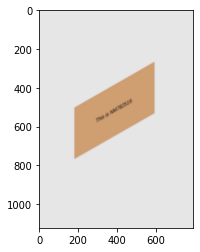

Fixed image


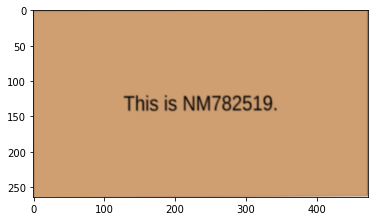


Original Image of cv3.png


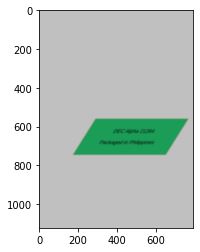

Fixed image


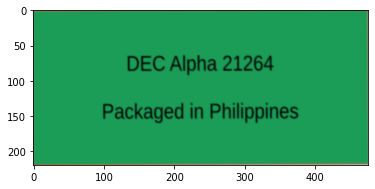


Original Image of cv1.png


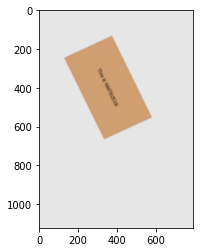

Fixed image


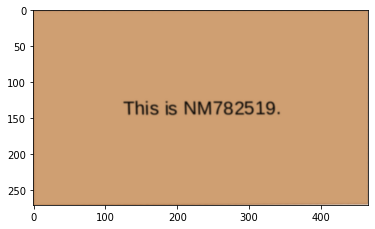

In [9]:
images = [f for f in listdir('Data/') if isfile(join('Data/',f))]

for i in range(len(images)):
    path = 'Data/'+images[i]
    print('Original Image of ' + images[i])
    image = cv2.imread(path)
    plt.imshow(image, interpolation = 'bicubic')
    plt.show()
    
    temp = RotateImg(path)  # Step 1
    fixed = WarpImg(temp)  # Step 2
    cv2.imwrite('Fixed_data/'+images[i][:-4]+'_fixed.png', fixed)
    print('Fixed image')
    plt.imshow(fixed, interpolation = 'bicubic')
    plt.show()
    print()

In [10]:
fixedImages = [f for f in listdir('Fixed_data/') if isfile(join('Fixed_data/',f))]
print()

# OCR for all the fixed images
for i in range(len(fixedImages)):
    print('OCR for ' + fixedImages[i])
    path = 'Fixed_data/'+str(fixedImages[i])
    print(OCR(path))  # Step 3
    print()


OCR for cv2_fixed.png
This is NM782519.

OCR for cv1_fixed.png
This is NM782519.

OCR for cv3_fixed.png
DEC Alpha 21264

Packaged in Philippines



## The End